In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#connecting drive with notebook
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [3]:
#imports
import numpy as np
import pandas as pd
import os
import math
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from tqdm import tqdm
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from tqdm import tqdm
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers, regularizers

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
os.chdir("/content/drive/MyDrive/case study 1")

In [5]:
#the train data
train = pd.read_csv('train.tsv',sep='\t')
#As on mercari only items wtih price ranged $3-$2000 are sold
train = train[(train.price >= 3) & (train.price <= 2000)].reset_index(drop=True)

In [ ]:
train.head(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...


In [6]:
#splitting data into train and cross validation
#ref : https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s
cv = KFold(n_splits=20, shuffle=True, random_state=42)
train_ids, test_ids = next(cv.split(train))
X_train, X_cv = train.iloc[train_ids], train.iloc[test_ids]

In [ ]:
os.chdir("/content/drive/MyDrive/case study 1/mercari price suggestion challenge")
#loading the text data which has approx 3.46m datapoints
test = pd.read_csv('test_stg2.tsv', sep='\t')
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


##Applying preprocessing steps


In [7]:
def preprocessing(data):
  #filling missing values with missing
  data["category_name"].fillna("missing", inplace=True)
  print("Number of Missing Values in Category Name : ", data['category_name'].isnull().sum())

  data['main_category'],data['sub_category1'],data['sub_category2']=data['category_name'].str.split("/",2).str

  data["sub_category1"].fillna("missing", inplace=True)
  print("Number of Missing Values in sub_category1 : ", data['sub_category1'].isnull().sum())

  data["sub_category2"].fillna("missing", inplace=True)
  print("Number of Missing Values in sub_category2 : ", data['sub_category2'].isnull().sum())

  data["brand_name"].fillna("missing", inplace=True)
  print("Number of Missing Values in brand_name : ", data['brand_name'].isnull().sum())

  data["item_description"].fillna("No description yet", inplace=True)
  print("Number of Missing Values in item_description : ", data['item_description'].isnull().sum())

  all_stopwords=set(stopwords.words('english'))

  # https://stackoverflow.com/a/47091490/4084039
  #applied ai course


  def decontracted(phrase):
      # specific
      phrase = re.sub(r"won't", "will not", phrase)
      phrase = re.sub(r"can\'t", "can not", phrase)

      # general
      phrase = re.sub(r"n\'t", " not", phrase)
      phrase = re.sub(r"\'re", " are", phrase)
      phrase = re.sub(r"\'s", " is", phrase)
      phrase = re.sub(r"\'d", " would", phrase)
      phrase = re.sub(r"\'ll", " will", phrase)
      phrase = re.sub(r"\'t", " not", phrase)
      phrase = re.sub(r"\'ve", " have", phrase)
      phrase = re.sub(r"\'m", " am", phrase)
      return phrase

  # https://gist.github.com/sebleier/554280
  def text_preprocessing(data):
    """this function performs preprocessing the item_description """
    preprocessed_total = []
    for sentance in tqdm(data):
      sent = decontracted(sentance)
      sent = sent.replace('\\r', ' ')
      sent = sent.replace('\\"', ' ')
      sent = sent.replace('\\n', ' ')
      sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
      sent = ' '.join(e for e in sent.split() if e.lower() not in all_stopwords) #removing stop words
      preprocessed_total.append(sent.lower().strip())
    return preprocessed_total

  preprocessed__descriptions=text_preprocessing(data['item_description'])
  data['item_description']=preprocessed__descriptions

  preprocessed_name=text_preprocessing(data['name'])
  data['name']=preprocessed_name

  return data




In [8]:
X_train = preprocessing(X_train)
X_cv = preprocessing(X_cv)

Number of Missing Values in Category Name :  0
Number of Missing Values in sub_category1 :  0
Number of Missing Values in sub_category2 :  0
Number of Missing Values in brand_name :  0


  0%|          | 3878/1407575 [00:00<00:36, 38777.26it/s]

Number of Missing Values in item_description :  0


100%|██████████| 1407575/1407575 [00:19<00:00, 71347.33it/s]


Number of Missing Values in Category Name :  0


  6%|▌         | 4143/74083 [00:00<00:01, 41428.46it/s]

Number of Missing Values in sub_category1 :  0
Number of Missing Values in sub_category2 :  0
Number of Missing Values in brand_name :  0
Number of Missing Values in item_description :  0


100%|██████████| 74083/74083 [00:01<00:00, 70940.03it/s]


In [ ]:
test = preprocessing(test)

Number of Missing Values in Category Name :  0
Number of Missing Values in sub_category1 :  0
Number of Missing Values in sub_category2 :  0
Number of Missing Values in brand_name :  0


  0%|          | 4006/3460725 [00:00<01:26, 40055.17it/s]

Number of Missing Values in item_description :  0


100%|██████████| 3460725/3460725 [00:46<00:00, 73703.01it/s]


In [9]:
def feature_engineering(data):
  #combining two or more features to create new feature
  data['name_description']=(data['name']+" " + data['item_description']+ " " + data['main_category'] + " " + data['sub_category1']+ " " + data['sub_category2']).astype(str)
  data['name_brand_name']=(data['name']+" " + data['brand_name'] ).astype(str)

  #if brand is know the item is branded else unbranded
  def branded_or_not(data):
    brand_known_or_not=[]
    """This function checks if brand name is missing or not"""
    for brands in tqdm(data):
      if brands=="missing":
        brand_known_or_not.append(0)
      else:
        brand_known_or_not.append(1)
    return brand_known_or_not

  data['brand_known_or_not']=branded_or_not(data['brand_name'])

  return data




  

In [10]:
X_train = feature_engineering(X_train)
X_cv = feature_engineering(X_cv)

100%|██████████| 74083/74083 [00:00<00:00, 1983104.04it/s]


In [ ]:
X_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,sub_category1,sub_category2,name_description,name_brand_name,brand_known_or_not
0,0,mlb cincinnati reds shirt size xl,3,Men/Tops/T-shirts,missing,10.0,1,description yet,Men,Tops,T-shirts,mlb cincinnati reds shirt size xl description ...,mlb cincinnati reds shirt size xl missing,0
1,1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,keyboard great condition works like came box p...,Electronics,Computers & Tablets,Components & Parts,razer blackwidow chroma keyboard keyboard grea...,razer blackwidow chroma keyboard Razer,1
2,2,ava viv blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,adorable top hint lace key hole back pale pink...,Women,Tops & Blouses,Blouse,ava viv blouse adorable top hint lace key hole...,ava viv blouse Target,1
3,3,leather horse statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,new tags leather horses retail rm stand foot h...,Home,Home Décor,Home Décor Accents,leather horse statues new tags leather horses ...,leather horse statues missing,0
4,4,24k gold plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,complete certificate authenticity,Women,Jewelry,Necklaces,24k gold plated rose complete certificate auth...,24k gold plated rose missing,0


In [ ]:
test = feature_engineering(test)

100%|██████████| 3460725/3460725 [00:01<00:00, 2667219.77it/s]


In [11]:
#using standard scaler on price feature after converting it to log(1+price)
#converting price to log(1+price) helps us counter the price = 0 while computing the RMSLE score
scaler = StandardScaler()
train_price = X_train['price'].values.reshape(-1,1)
cv_price = X_cv['price'].values.reshape(-1,1)

y_train = scaler.fit_transform(np.log1p(train_price))
y_cv = scaler.transform(np.log1p(cv_price))

print("X_Train Data Shape : ",X_train.shape)
print("y_train Shape : ",y_train.shape)
print("X_cv Data Shape : ",X_cv.shape)
print("y_cv Shape : ",y_cv.shape)
y_train.shape

X_Train Data Shape :  (1407575, 14)
y_train Shape :  (1407575, 1)
X_cv Data Shape :  (74083, 14)
y_cv Shape :  (74083, 1)


(1407575, 1)

#Dataset1 : Bag of word features

1.   2 models will be trained on this dataset with different batch sizes
2.   The models trained will be ensembled together



In [12]:
#enconding item  description using bag of words where minimum occurance is 50 and maximum features is 50000.
vectorizer_bow = CountVectorizer(max_features=100000,token_pattern='\w+', dtype=np.float32 , ngram_range=(1,2))
vectorizer_bow.fit(X_train['name_description'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_combined_text_feature_bow = vectorizer_bow.transform(X_train['name_description'].values)
X_cv_combined_text_feature_bow = vectorizer_bow.transform(X_cv['name_description'].values)

print(X_train_combined_text_feature_bow.shape)
print(X_cv_combined_text_feature_bow.shape)

(1407575, 100000)
(74083, 100000)


In [ ]:
X_test_combined_text_feature_bow = vectorizer_bow.transform(test['name_description'].values)
print(X_test_combined_text_feature_bow.shape)

(3460725, 100000)


In [13]:
#enconding item  description using bag of words where minimum occurance is 50 and maximum features is 50000.
vectorizer_name_brand_name = CountVectorizer(max_features=100000,token_pattern='\w+', dtype=np.float32)
vectorizer_name_brand_name.fit(X_train['name_brand_name'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_combined_name_feature_bow = vectorizer_name_brand_name.transform(X_train['name_brand_name'].values)
X_cv_combined_name_feature_bow = vectorizer_name_brand_name.transform(X_cv['name_brand_name'].values)

print(X_train_combined_name_feature_bow.shape)
print(X_cv_combined_name_feature_bow.shape)

(1407575, 100000)
(74083, 100000)


In [ ]:
X_test_combined_name_feature_bow = vectorizer_name_brand_name.transform(test['name_brand_name'].values)
print(X_test_combined_name_feature_bow.shape)

(3460725, 100000)


#Dataset2 : Tfidf features
1.   2 models will be trained on this dataset with different batch sizes
2.   The models trained will be ensembled together

In [14]:
#enconding item  description using bag of words where minimum occurance is 50 and maximum features is 50000.
vectorizer_tfidf = TfidfVectorizer(max_features=100000,token_pattern='\w+', dtype=np.float32 , ngram_range=(1,2))
vectorizer_tfidf.fit(X_train['name_description'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_combined_text_feature_tfidf = vectorizer_tfidf.transform(X_train['name_description'].values)
X_cv_combined_text_feature_tfidf = vectorizer_tfidf.transform(X_cv['name_description'].values)

print(X_train_combined_text_feature_tfidf.shape)
print(X_cv_combined_text_feature_tfidf.shape)

(1407575, 100000)
(74083, 100000)


In [ ]:
X_test_combined_text_feature_tfidf = vectorizer_tfidf.transform(test['name_description'].values)
print(X_test_combined_text_feature_tfidf.shape)

(3460725, 100000)


In [15]:
#enconding item  description using bag of words where minimum occurance is 50 and maximum features is 50000.
vectorizer_name_brand_name_tfidf = TfidfVectorizer(max_features=100000,token_pattern='\w+', dtype=np.float32)
vectorizer_name_brand_name_tfidf.fit(X_train['name_brand_name'].values)

# we use the fitted CountVectorizer to convert the text to vector
X_train_combined_name_feature_tfidf = vectorizer_name_brand_name_tfidf.transform(X_train['name_brand_name'].values)
X_cv_combined_name_feature_tfidf = vectorizer_name_brand_name_tfidf.transform(X_cv['name_brand_name'].values)

print(X_train_combined_name_feature_tfidf.shape)
print(X_cv_combined_name_feature_tfidf.shape)

(1407575, 100000)
(74083, 100000)


In [ ]:
X_test_combined_name_feature_tfidf = vectorizer_name_brand_name_tfidf.transform(test['name_brand_name'].values)
print(X_test_combined_name_feature_tfidf.shape)

(3460725, 100000)


In [16]:
label_item_condition = LabelEncoder()
label_item_condition.fit(X_train['item_condition_id'].values)
print(list(label_item_condition.classes_))

X_train['item_condition_id'] = label_item_condition.transform(X_train['item_condition_id'].values)
X_cv["item_condition_id"] = X_cv["item_condition_id"].map(lambda s: 2 if s not in list(label_item_condition.classes_) else s)

X_cv['item_condition_id'] = label_item_condition.transform(X_cv['item_condition_id'].values)

[1, 2, 3, 4, 5]


In [ ]:
test["item_condition_id"] = test["item_condition_id"].map(lambda s: 2 if s not in list(label_item_condition.classes_) else s)
test['item_condition_id'] = label_item_condition.transform(test['item_condition_id'].values)

In [17]:
label_shipping = LabelEncoder()
label_shipping.fit(X_train['shipping'])

X_train['shipping'] = label_shipping.transform(X_train['shipping'])
X_cv["shipping"] = X_cv["shipping"].map(lambda s: 0 if s not in label_shipping.classes_ else s)
X_cv['shipping'] = label_shipping.transform(X_cv['shipping'])

In [ ]:
test["shipping"] = test["shipping"].map(lambda s: 0 if s not in label_shipping.classes_ else s)
test['shipping'] = label_shipping.transform(test['shipping'])

In [18]:
label_brand_known_or_not = LabelEncoder()
X_train['brand_known_or_not'] = label_brand_known_or_not.fit_transform(X_train['brand_known_or_not'])
X_cv["brand_known_or_not"] = label_brand_known_or_not.transform(X_cv['brand_known_or_not'])

In [ ]:
test["brand_known_or_not"] = label_brand_known_or_not.transform(test['brand_known_or_not'])

In [19]:
#one hot encoding categorical features and then padding them to make them of equal size
from sklearn.preprocessing import OneHotEncoder

ohe_item_condition = OneHotEncoder(dtype=np.float32)
X_train_item_condition_id_ohe = ohe_item_condition.fit_transform(np.array(X_train['item_condition_id']).reshape(-1,1))
X_cv_item_condition_id_ohe = ohe_item_condition.transform(np.array(X_cv['item_condition_id']).reshape(-1,1))

ohe_brand_known_or_not = OneHotEncoder(dtype=np.float32)
X_train_brand_known_or_not_ohe = ohe_brand_known_or_not.fit_transform(np.array(X_train['brand_known_or_not']).reshape(-1,1))
X_cv_brand_known_or_not_ohe = ohe_brand_known_or_not.transform(np.array(X_cv['brand_known_or_not']).reshape(-1,1))

ohe_shipping = OneHotEncoder(dtype=np.float32)
X_train_shipping_ohe = ohe_shipping.fit_transform(np.array(X_train['shipping']).reshape(-1,1))
X_cv_shipping_ohe = ohe_shipping.transform(np.array(X_cv['shipping']).reshape(-1,1))


In [ ]:
X_test_item_condition_id_ohe = ohe_item_condition.transform(np.array(test['item_condition_id']).reshape(-1,1))
X_test_brand_known_or_not_ohe = ohe_brand_known_or_not.transform(np.array(test['brand_known_or_not']).reshape(-1,1))
X_test_shipping_ohe = ohe_shipping.transform(np.array(test['shipping']).reshape(-1,1))

In [20]:
X_train_item_condition_id_ohe.shape

(1407575, 5)

In [21]:
#stacking one hot encoded features along with tfidf weighted word vectorization of text features which were combined into one into a single matrix
#convert them into csr matrix as they are save space while operating on sparse matrices
X_tr_bow = hstack((
    X_train_combined_text_feature_bow,
    X_train_combined_name_feature_bow,
    X_train_item_condition_id_ohe,
    X_train_brand_known_or_not_ohe,
    X_train_shipping_ohe
    )).tocsr()

X_cv_bow = hstack((
    X_cv_combined_text_feature_bow,
    X_cv_combined_name_feature_bow,
    X_cv_item_condition_id_ohe,
    X_cv_brand_known_or_not_ohe,
    X_cv_shipping_ohe,
    )).tocsr()


#feature_names=feature_name0+feature_name1+feature_name2+feature_name3+feature_name4+feature_name5+feature_name6+feature_name7
print("Final Data matrix")
print(X_tr_bow.shape)
print(X_cv_bow.shape)

Final Data matrix
(1407575, 200009)
(74083, 200009)


In [ ]:
X_test_bow = hstack((
    X_test_combined_text_feature_bow,
    X_test_combined_name_feature_bow,
    X_test_item_condition_id_ohe,
    X_test_brand_known_or_not_ohe,
    X_test_shipping_ohe,
    )).tocsr()

print(X_test_bow.shape)

(3460725, 200009)


In [22]:
#stacking one hot encoded features along with tfidf weighted word vectorization of text features which were combined into one into a single matrix
#convert them into csr matrix as they are save space while operating on sparse matrices
X_tr_tfidf = hstack((
    X_train_combined_text_feature_tfidf,
    X_train_combined_name_feature_tfidf,
    X_train_item_condition_id_ohe,
    X_train_brand_known_or_not_ohe,
    X_train_shipping_ohe
    )).tocsr()

X_cv_tfidf = hstack((
    X_cv_combined_text_feature_tfidf,
    X_cv_combined_name_feature_tfidf,
    X_cv_item_condition_id_ohe,
    X_cv_brand_known_or_not_ohe,
    X_cv_shipping_ohe
    )).tocsr()


#feature_names=feature_name0+feature_name1+feature_name2+feature_name3+feature_name4+feature_name5+feature_name6+feature_name7
print("Final Data matrix")
print(X_tr_tfidf.shape)
print(X_cv_tfidf.shape)

Final Data matrix
(1407575, 200009)
(74083, 200009)


In [ ]:
X_test_tfidf = hstack((
    X_test_combined_text_feature_tfidf,
    X_test_combined_name_feature_tfidf,
    X_test_item_condition_id_ohe,
    X_test_brand_known_or_not_ohe,
    X_test_shipping_ohe,
    )).tocsr()

print(X_test_tfidf.shape)

(3460725, 200009)


In [23]:
# Reference : https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113064

def rmsle_score(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [24]:
#defining model
#model is based on the model that was used by competition winner with little tuning to match our requirements
# ref : https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s
def sparse_mlp(input_shape):
    input_layer = Input(shape=(input_shape,), dtype='float32', sparse=True)

    layer1 = Dense(256, activation = "relu",kernel_initializer=tf.keras.initializers.he_uniform(seed = 42))(input_layer)
    dropout_layer1 = Dropout(0.2)(layer1)

    layer2 = Dense(128, activation = "relu",kernel_initializer=tf.keras.initializers.he_uniform(seed = 42))(dropout_layer1)

    layer3 = Dense(64, activation = "relu",kernel_initializer=tf.keras.initializers.he_uniform(seed = 42))(layer2)

    layer4 = Dense(32, activation = "relu",kernel_initializer=tf.keras.initializers.he_uniform(seed = 42))(layer3)

    output_layer = Dense(1,kernel_initializer=tf.keras.initializers.he_uniform(seed = 42))(layer4)

    model1 = Model(inputs = input_layer, outputs = output_layer)
    return model1

In [25]:
model1 = sparse_mlp(200009)
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200009)]          0         
_________________________________________________________________
dense (Dense)                (None, 256)               51202560  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33    

In [26]:
def cal_rmsle(model,val_data):
  '''to compute rmsle score for each iteration'''
  y_pred = model.predict(val_data)[:,0]
  y_pred = np.expm1(scaler.inverse_transform(y_pred.reshape(-1, 1))[:, 0])
  print("RMSLE : ", rmsle_score(cv_price,y_pred))

In [27]:
#fitting model twice to two different batch size,it reduces training time.
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss = "mean_squared_error")
for i in range(2):
  model1.fit(X_tr_bow,y_train, batch_size= 2**(8+i), epochs = 1, verbose = 1,validation_data = (X_cv_bow,y_cv))
  cal_rmsle(model1,X_cv_bow)

5499/5499 [==============================] - 39s 7ms/step - loss: 0.4154 - val_loss: 0.3158
RMSLE :  0.4190922390657584
2750/2750 [==============================] - 23s 8ms/step - loss: 0.2463 - val_loss: 0.2983
RMSLE :  0.4073314668616297


In [29]:
y_pred_1 = model1.predict(X_cv_bow)[:,0]
y_pred_1 = np.expm1(scaler.inverse_transform(y_pred_1.reshape(-1, 1))[:, 0])
print("CV RMSLE from MLP BoW batch size 512 : ", rmsle_score(cv_price,y_pred_1))

CV RMSLE from MLP BoW batch size 512 :  0.40733146692251226


In [30]:
y_pred_train_1 = model1.predict(X_tr_bow)[:,0]
y_pred_train_1 = np.expm1(scaler.inverse_transform(y_pred_train_1.reshape(-1, 1))[:, 0])
print("Train RMSLE from MLP BoW batch size 512 : ", rmsle_score(train_price,y_pred_train_1))

Train RMSLE from MLP BoW batch size 512 :  0.30892197877566363


In [ ]:
model1 = tf.keras.models.load_model("mlp_model1.h5")
y_pred_test_1 = model1.predict(X_test_bow)[:,0]

In [ ]:
model1.save("mlp_model1.h5")

In [31]:
model2 = sparse_mlp(200009)
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss = "mean_squared_error")
for i in range(1):
  model2.fit(X_tr_bow,y_train, batch_size= 2**(6+i), epochs = 1, verbose = 1,validation_data = (X_cv_bow,y_cv))
  cal_rmsle(model2,X_cv_bow)

21994/21994 [==============================] - 132s 6ms/step - loss: 0.4221 - val_loss: 0.3181
RMSLE :  0.4206543895347296


In [32]:
model2.fit(X_tr_bow,y_train, batch_size=128 , epochs = 1, verbose = 1,validation_data = (X_cv_bow,y_cv))

10997/10997 [==============================] - 70s 6ms/step - loss: 0.2620 - val_loss: 0.2973


In [33]:
y_pred_2 = model2.predict(X_cv_bow)[:,0]
y_pred_2 = np.expm1(scaler.inverse_transform(y_pred_2.reshape(-1, 1))[:, 0])
print("CV RMSLE from MLP BoW batch size 128 : ", rmsle_score(cv_price,y_pred_2))

CV RMSLE from MLP BoW batch size 128 :  0.40667962525902823


In [34]:
y_pred_train_2 = model2.predict(X_tr_bow)[:,0]
y_pred_train_2 = np.expm1(scaler.inverse_transform(y_pred_train_2.reshape(-1, 1))[:, 0])
print("Train RMSLE from MLP BoW batch size 128 : ", rmsle_score(train_price,y_pred_train_2))

Train RMSLE from MLP BoW batch size 128 :  0.3218021845330773


In [ ]:
model2.save("mlp_model2.h5")

In [ ]:
model2 = tf.keras.models.load_model("mlp_model2.h5")
y_pred_test_2 = model2.predict(X_test_bow)[:,0]

In [37]:
#finding best weights for ensembling
weights = np.linspace(0,1,30)
weight_value = []
predicted_value = []
for weight in weights:
  prediction = weight * y_pred_1 + (1 - weight) * y_pred_2
  predicted_value.append(rmsle_score(cv_price,prediction))
  weight_value.append(weight)

In [38]:
index = np.argmin(predicted_value)
print("Min RMSLE Score : ", predicted_value[index])
print("Weights Proportion : ", weight_value[index])

Min RMSLE Score :  0.39889107849884226
Weights Proportion :  0.48275862068965514


In [54]:
y_prediction_cv_bow = np.average([y_pred_1, y_pred_2], weights=[0.48, 0.52], axis=0)
y_prediction_train_bow = np.average([y_pred_train_1, y_pred_train_2], weights=[0.48, 0.52], axis=0)

In [55]:
print("CV RMSLE of ensemble of MLP BoW  : ", rmsle_score(cv_price,y_prediction_cv_bow))
print("Train RMSLE of ensemble of MLP BoW  : ", rmsle_score(train_price,y_prediction_train_bow))

CV RMSLE of ensemble of MLP BoW  :  0.3988911125371772
Train RMSLE of ensemble of MLP BoW  :  0.30437293684216143


In [ ]:
y_prediction_test_bow = np.average([y_pred_test_1, y_pred_test_2], weights=[0.55, 0.45], axis=0)

In [ ]:
model3 = sparse_mlp(200009)
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss = "mean_squared_error")
for i in range(2):
  model3.fit(X_tr_tfidf,y_train, batch_size= 2**(8+i), epochs = 1, verbose = 1,validation_data = (X_cv_tfidf,y_cv))
  cal_rmsle(model3,X_cv_tfidf)

5499/5499 [==============================] - 93s 16ms/step - loss: 0.4012 - val_loss: 0.3092
RMSLE :  0.414700924732028
2750/2750 [==============================] - 53s 19ms/step - loss: 0.2324 - val_loss: 0.2943
RMSLE :  0.40459968893285586


In [ ]:
model3.save("mlp_model3.h5")

In [44]:
y_pred_3 = model3.predict(X_cv_tfidf)[:,0]
y_pred_3 = np.expm1(scaler.inverse_transform(y_pred_3.reshape(-1, 1))[:, 0])
print("CV RMSLE from MLP Tfidf batch size 512 : ", rmsle_score(cv_price,y_pred_3))

CV RMSLE from MLP Tfidf batch size 512 :  0.40459968859914774


In [46]:
y_pred_train_3 = model3.predict(X_tr_tfidf)[:,0]
y_pred_train_3 = np.expm1(scaler.inverse_transform(y_pred_train_3.reshape(-1, 1))[:, 0])
print("Train RMSLE from MLP BoW batch size 512 : ", rmsle_score(train_price,y_pred_train_3))

Train RMSLE from MLP BoW batch size 512 :  0.2896834412790256


In [ ]:
model3 = tf.keras.models.load_model("mlp_model3.h5")
y_pred_test_3 = model3.predict(X_test_tfidf)[:,0]

In [ ]:
model4 = sparse_mlp(200009)
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss = "mean_squared_error")
for i in range(2):
  model4.fit(X_tr_tfidf,y_train, batch_size= 2**(6+i), epochs = 1, verbose = 1,validation_data = (X_cv_tfidf,y_cv))
  cal_rmsle(model4,X_cv_tfidf)

21994/21994 [==============================] - 331s 15ms/step - loss: 0.4045 - val_loss: 0.3128
RMSLE :  0.41711863218560696
10997/10997 [==============================] - 172s 16ms/step - loss: 0.2494 - val_loss: 0.2945
RMSLE :  0.4047565765534879


In [ ]:
model4.save('mlp_model4.h5')

In [48]:
model4 = tf.keras.models.load_model("mlp_model4.h5")

In [49]:
y_pred_4 = model4.predict(X_cv_tfidf)[:,0]
y_pred_4 = np.expm1(scaler.inverse_transform(y_pred_4.reshape(-1, 1))[:, 0])
print("CV RMSLE from MLP Tfidf batch size 128 : ", rmsle_score(cv_price,y_pred_4))

CV RMSLE from MLP Tfidf batch size 128 :  0.40475657622868055


In [50]:
y_pred_train_4 = model4.predict(X_tr_tfidf)[:,0]
y_pred_train_4 = np.expm1(scaler.inverse_transform(y_pred_train_4.reshape(-1, 1))[:, 0])
print("Train RMSLE from MLP BoW batch size 128 : ", rmsle_score(train_price,y_pred_train_4))

Train RMSLE from MLP BoW batch size 128 :  0.3090983751064142


In [51]:
del model4

In [ ]:
model4 = tf.keras.models.load_model("mlp_model4.h5")
y_pred_test_4 = model4.predict(X_test_tfidf)[:,0]

In [52]:
weights = np.linspace(0,1,30)
weight_value = []
predicted_value = []
for weight in weights:
  prediction = weight * y_pred_3 + (1 - weight) * y_pred_4
  predicted_value.append(rmsle_score(cv_price,prediction))
  weight_value.append(weight)

In [53]:
index = np.argmin(predicted_value)
print("Min RMSLE Score : ", predicted_value[index])
print("Weights Proportion : ", weight_value[index])

Min RMSLE Score :  0.3974275796611608
Weights Proportion :  0.48275862068965514


In [56]:
y_prediction_tfidf = np.average([y_pred_3, y_pred_4], weights=[0.48, 0.52], axis=0)
y_prediction_train_tfidf = np.average([y_pred_train_3, y_pred_train_3], weights=[0.48, 0.52], axis=0)

In [57]:
print("CV RMSLE of ensemble of MLP Tfidf  : ", rmsle_score(cv_price,y_prediction_tfidf))
print("Train RMSLE of ensemble of MLP Tfidf  : ", rmsle_score(train_price,y_prediction_train_tfidf))

CV RMSLE of ensemble of MLP Tfidf  :  0.39742932947566767
Train RMSLE of ensemble of MLP Tfidf  :  0.2896834412790256


In [ ]:
y_prediction_test_tfidf = np.average([y_pred_test_3, y_pred_test_4], weights=[0.48, 0.52], axis=0)

In [66]:
weights = np.linspace(0,1,30)
weight_value = []
predicted_value = []
for weight in weights:
  prediction = weight * y_prediction_cv_bow + (1 - weight) * y_prediction_tfidf
  predicted_value.append(rmsle_score(cv_price,prediction))
  weight_value.append(weight)

In [67]:
index = np.argmin(predicted_value)
print("Min RMSLE Score : ", predicted_value[index])
print("Weights Proportion : ", weight_value[index])

Min RMSLE Score :  0.3921817214625909
Weights Proportion :  0.48275862068965514


In [63]:
y_prediction_3 = np.average([y_prediction_cv_bow, y_prediction_tfidf], weights=[0.48, 0.52], axis=0)
y_prediction_4 = np.average([y_prediction_train_bow, y_prediction_train_tfidf], weights=[0.48, 0.52], axis=0)
print(rmsle_score(cv_price,y_prediction_3))
print(rmsle_score(train_price,y_prediction_4))

0.3921802368444528
0.2862742462087863


In [ ]:
y_prediction_test = np.average([y_prediction_test_bow, y_prediction_test_tfidf], weights=[0.44, 0.56], axis=0)

In [ ]:
y_prediction_test

array([-1.382818  , -1.05570294,  1.32345545, ..., -0.31673856,
        0.18733837,  0.36520796])

In [ ]:
test_id = [i for i in range(len(y_prediction_test))]
y_prediction_test = np.expm1(scaler.inverse_transform(y_prediction_test.reshape(-1, 1))[:, 0])
df_submission = pd.DataFrame({'test_id': test_id, 'price': y_prediction_test})
df_submission.head()

,test_id,price
0,0,6.024095
1,1,7.964895
2,2,51.865329
3,3,12.451687
4,4,8.187813


In [ ]:
df_submission.to_csv("submission_final_mlp_bow.csv",index = False)

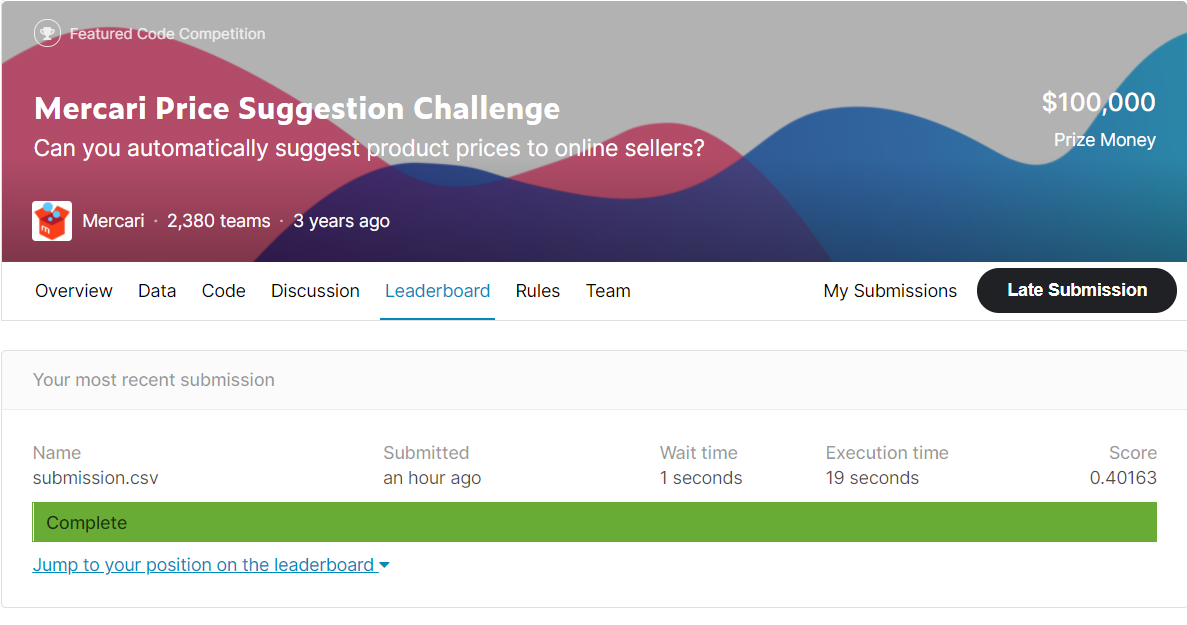

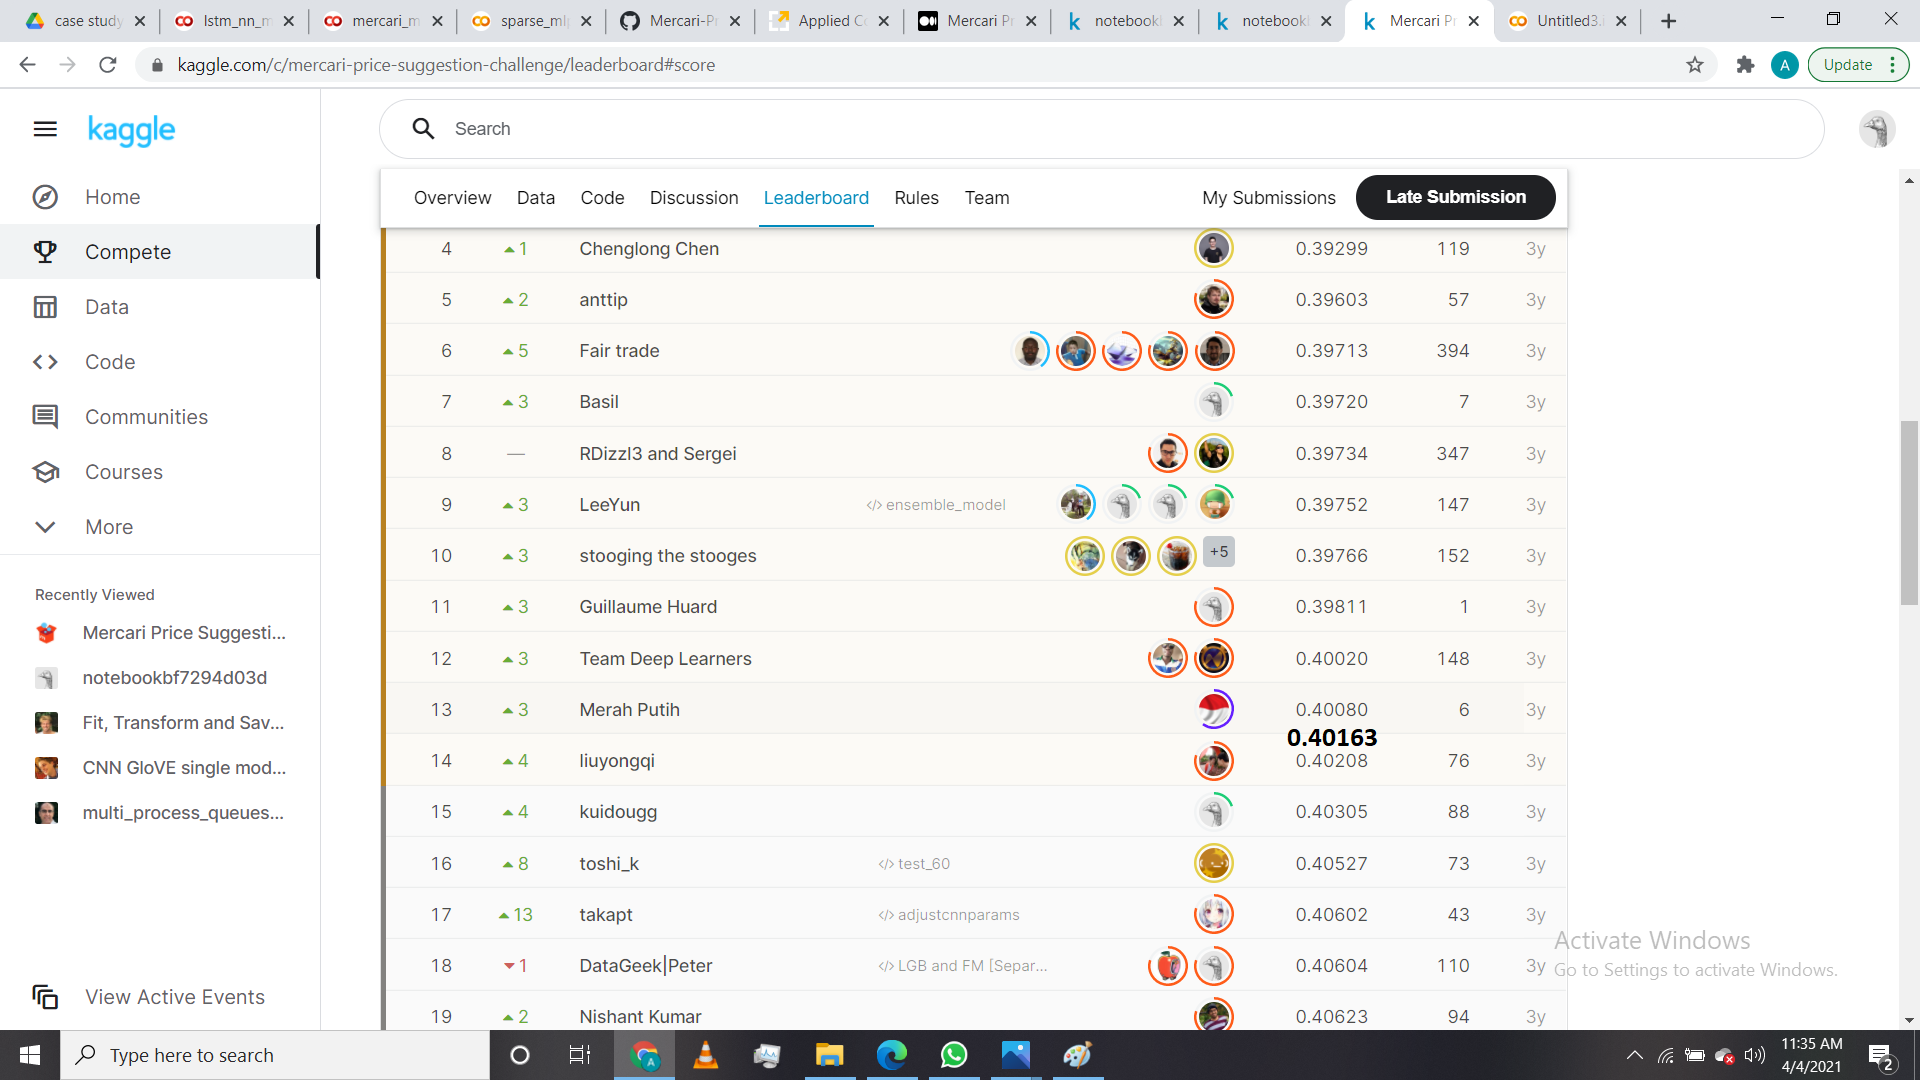